In [4]:
import numpy as np
import matplotlib.pyplot as plt

# A few notes about my coding style
- In (nested) loops, I always try to first use "i" as a loop variable, then "j", "k", etc. If it's e.g. steps, then I normally use "s" for the loop variable
- Normal variables I always put lowercase, while local function variables are always uppercase to distinguish between them easier
- Cells starting with "# x" are not necessary for the running of the simulation (e.g. checkup, documentation)
- Let me know if you rather use a different style, I dont have a problem with using a different style!

In [5]:
# Functions

def Distance_Between_Bodies(Ndim, Body1, Body2):
    """calculates the distance between two argon atoms in a given number of dimensions."""
    
    Pos1 = Body1[1:Ndim]
    Pos2 = Body2[1:Ndim]
    R = np.sqrt( np.sum( (Pos1-Pos2)**2 ) )
    return R

def Single_Body_Acc(S, Bodies, Body_Index, Limited=False):
    """finds the acceleration on a single body by LJ-Potential from others."""

    Body_Index = int(Body_Index)
    Body = Bodies[S, Body_Index]
    Pos1 = Body[1:1+ndim]
    Acc = np.asarray([0, 0, 0])
    Mass = Body[0]
    
    SumEpot = 0
    
    # Go through the rest of bodies to calc acc
    for I, Other_Body in enumerate(Bodies[S, :, :]):
        if int(I) != Body_Index:
            # implement minimal image convention:
            Other_Body = Minimal_Image_Convention(S, Body, Other_Body, lBox)
            
            # calc distances and else with new 
            Pos2 = Other_Body[1:1+ndim]
            DPos = Pos2 - Pos1
            R = Distance_Between_Bodies(ndim, Body, Other_Body)
            
            # try gravity interaction to get it work, then switch to LJ
            Scalar_Acc = 1*Mass*Other_Body[0]/np.power(R, 3.)
            # split up vec(acc) in scalar acc = abs(a)/r, and vec(e_a) = vec(r)
            # Scalar_Acc = 4*epsilon/Mass*( -12.*np.power(sigma, 12.)*np.power(R, -14.) + 6.*np.power(sigma, 6.)*np.power(R, -8.) )
            #Acc = np.add(Acc, Scalar_Acc*DPos)
            
            # calculate potential energy in that potential
            #dU = 4*epsilon*(np.power(sigma/R, 12) - np.power(sigma/R, 6.))
            
            
            # Updated by Ruoyan
            # Convert potential energy and scalar acceleration to dimensionless
            # With convertion, length will be in units of sigma, energy in units of epsilon, 
            # and time in units of (m*sigma**2/epsilon)**(1/2)
            # Note to Robin: We may need to discuss calculating the gradient of potential
            # It seems unnecessary to divide the expression by r if we are only dealing with scalar
            # Scalar_Acc = 4*epsilon/(Mass*sigma**2)*(12*(R)**(-14) - 6*(R)**(-8))
            Acc = np.add(Acc, Scalar_Acc*DPos)
            
            dU = 4*epsilon*((R)**(-12) - R**(-6))
            SumEpot += dU
    
    return Acc, SumEpot

# return new pos of other body if too far away
def Minimal_Image_Convention(S, Body, Other_Body, LBox):
    Pos1 = Body[1:1+ndim]
    Pos2 = Other_Body[1:1+ndim]
    DPos = Pos2 - Pos1
    NewOther = np.zeros_like(Other_Body)
    NewOther[:] = Other_Body[:]
    # go through all three dimensions D and check if the other body is farther away than half a box:
    # if so, add or subtract box size from pos of other body:
    for D in range(3):
        if DPos[D] > LBox/2:
            NewOther[1+D] = Pos2[D] - LBox
        elif DPos[D] < -LBox/2:
            NewOther[1+D] = Pos2[D] + LBox
            
    
    return NewOther


In [36]:
# Make initial conditions
# 
nbodies = 10
ndim = 3
tend = .1
dt = 1E-4 # time
nsteps = int(tend/dt)
particle_data = np.zeros((nsteps, nbodies, 1 + 2*ndim))
# energies: t, Ekin, Epot, Etot
energies = np.zeros((nsteps, 4))

# set initial position, velocities
# size of box
lBox = 3.
# limits of pos, vel
x0, x1 = 0., lBox
v0, v1 = -.1, .1
particle_data[0, :, 1:4] = np.random.uniform(x0, x1, particle_data[0, :, 1:4].shape)
particle_data[0, :, 4:] = np.random.uniform(v0, v1, particle_data[0, :, 4:].shape)
# set particle masss
particle_data[:, :, 0] = 1
# sigma, epsilon for L-J-Potential
#sigma = 3.405 # in angstrom
sigma = .1
epsilon = np.power(2., 1/6)*sigma

In [37]:
# do the actual simulation:

for s in range(nsteps-1):
    # for every time step:
    Epot = 0.
    Ekin = 0.
    t = s*dt
    
    for i, body1 in enumerate(particle_data[s]):
        # for every particle:
        
        # get current pos, vel, mass
        mass = body1[0]
        pos1 = body1[1:1+ndim]
        vel1 = body1[1+ndim:]
        
        # Calc acc with current (old) positions
        oldacc, dEpot = Single_Body_Acc(s, particle_data, i)
        # Calc new positions and copy to data array
        newpos = pos1 + dt*vel1 + 0.5*dt*dt/mass*oldacc
        particle_data[s+1, i, 1:1+ndim] = newpos
        # Calc acc with new pos
        newacc = Single_Body_Acc(s+1, particle_data, i)[0]
        # Calc new vel with old and new acc, and copy to data array
        newvel = vel1 + 0.5*dt*dt/mass*( newacc - oldacc )
        print(newvel)
        particle_data[s+1, i, 1+ndim:1+2*ndim] = newvel
        
        # energies
        Epot += dEpot
        Ekin += 0.5*mass*np.sum(vel1*vel1)
    
    # put all particles back in the box:
    # it might be that this ruin all energy conservation
    particle_data[s+1, :, 1:4] = np.mod(particle_data[s+1, :, 1:4], lBox)
    
    # calculate the energies
    Etot = Epot + Ekin
    energies[s] = t, Ekin, Epot, Etot

[-0.04384692 -0.01527522  0.0946976 ]
[ 0.05197775 -0.05578447 -0.06809478]
[-0.02508792  0.01525789  0.00786436]
[ 0.04273855 -0.09954409  0.00261979]
[-0.02918436 -0.0373349  -0.0301762 ]
[-0.06306456 -0.03893985 -0.03967684]
[ 0.01638538 -0.00285019  0.09281758]
[ 0.01062847 -0.05474586 -0.02574231]
[-0.09750248 -0.05565255  0.04505366]
[0.04914298 0.06912997 0.04273179]
[-0.0438467  -0.01527519  0.09469759]
[ 0.05197777 -0.05578452 -0.06809481]
[-0.02508797  0.01525785  0.00786423]
[ 0.04273858 -0.09954413  0.00261973]
[-0.02918436 -0.03733493 -0.03017623]
[-0.06306456 -0.03893991 -0.03967671]
[ 0.01638534 -0.00285026  0.09281786]
[ 0.01062847 -0.05474585 -0.02574233]
[-0.09750248 -0.05565255  0.04505366]
[0.04914298 0.06912997 0.04273179]
[-0.04384649 -0.01527516  0.09469758]
[ 0.05197779 -0.05578456 -0.06809483]
[-0.02508803  0.01525781  0.0078641 ]
[ 0.0427386  -0.09954417  0.00261967]
[-0.02918437 -0.03733496 -0.03017625]
[-0.06306457 -0.03893998 -0.03967659]
[ 0.0163853  -0.00

[ 0.04273912 -0.09954511  0.00261827]
[-0.02918456 -0.0373357  -0.03017677]
[-0.06306469 -0.03894153 -0.03967362]
[ 0.01638435 -0.00285192  0.09282492]
[ 0.01062836 -0.05474545 -0.02574279]
[-0.09750255 -0.05565248  0.04505362]
[0.04914298 0.06912997 0.04273179]
[-0.04384119 -0.01527453  0.09469738]
[ 0.05197824 -0.0557856  -0.06809542]
[-0.02508936  0.01525675  0.00786083]
[ 0.04273914 -0.09954515  0.00261821]
[-0.02918457 -0.03733573 -0.03017679]
[-0.06306469 -0.0389416  -0.0396735 ]
[ 0.01638431 -0.00285199  0.0928252 ]
[ 0.01062836 -0.05474543 -0.02574281]
[-0.09750255 -0.05565248  0.04505362]
[0.04914298 0.06912997 0.04273179]
[-0.04384098 -0.0152745   0.09469737]
[ 0.05197825 -0.05578564 -0.06809545]
[-0.02508941  0.01525671  0.0078607 ]
[ 0.04273916 -0.09954519  0.00261815]
[-0.02918458 -0.03733576 -0.03017681]
[-0.0630647  -0.03894166 -0.03967338]
[ 0.01638427 -0.00285206  0.09282548]
[ 0.01062835 -0.05474542 -0.02574283]
[-0.09750255 -0.05565247  0.04505362]
[0.04914298 0.0691

[-0.02509091  0.01525552  0.00785703]
[ 0.04273977 -0.09954628  0.00261652]
[-0.0291848  -0.03733662 -0.03017742]
[-0.06306484 -0.03894348 -0.03966992]
[ 0.01638315 -0.00285393  0.09283341]
[ 0.01062823 -0.05474497 -0.02574335]
[-0.09750263 -0.05565239  0.04505357]
[0.04914298 0.06912997 0.04273179]
[-0.04383483 -0.01527376  0.09469713]
[ 0.05197877 -0.05578684 -0.06809613]
[-0.02509096  0.01525548  0.0078569 ]
[ 0.04273979 -0.09954632  0.00261646]
[-0.02918481 -0.03733666 -0.03017745]
[-0.06306484 -0.03894354 -0.0396698 ]
[ 0.01638311 -0.002854    0.0928337 ]
[ 0.01062822 -0.05474496 -0.02574337]
[-0.09750263 -0.05565239  0.04505357]
[0.04914298 0.06912997 0.04273179]
[-0.04383462 -0.01527374  0.09469712]
[ 0.05197879 -0.05578688 -0.06809616]
[-0.02509101  0.01525544  0.00785677]
[ 0.04273981 -0.09954635  0.0026164 ]
[-0.02918481 -0.03733669 -0.03017747]
[-0.06306485 -0.03894361 -0.03966968]
[ 0.01638307 -0.00285406  0.09283398]
[ 0.01062822 -0.05474494 -0.02574338]
[-0.09750263 -0.05

[-0.04382847 -0.015273    0.09469688]
[ 0.05197931 -0.05578809 -0.06809684]
[-0.02509256  0.01525421  0.00785297]
[ 0.04274043 -0.09954748  0.00261472]
[-0.02918504 -0.03733758 -0.0301781 ]
[-0.063065   -0.03894548 -0.0396661 ]
[ 0.01638192 -0.00285601  0.09284222]
[ 0.01062809 -0.05474448 -0.02574392]
[-0.09750271 -0.0556523   0.04505352]
[0.04914298 0.06912997 0.04273179]
[-0.04382826 -0.01527297  0.09469687]
[ 0.05197933 -0.05578813 -0.06809687]
[-0.02509262  0.01525417  0.00785284]
[ 0.04274046 -0.09954752  0.00261466]
[-0.02918505 -0.03733761 -0.03017812]
[-0.063065   -0.03894555 -0.03966598]
[ 0.01638188 -0.00285608  0.09284251]
[ 0.01062809 -0.05474447 -0.02574394]
[-0.09750271 -0.0556523   0.04505351]
[0.04914298 0.06912997 0.04273179]
[-0.04382805 -0.01527295  0.09469686]
[ 0.05197935 -0.05578817 -0.06809689]
[-0.02509267  0.01525413  0.00785271]
[ 0.04274048 -0.09954756  0.0026146 ]
[-0.02918506 -0.03733764 -0.03017814]
[-0.06306501 -0.03894561 -0.03966586]
[ 0.01638184 -0.00

[-0.02509411  0.01525299  0.00784917]
[ 0.04274106 -0.09954861  0.00261304]
[-0.02918527 -0.03733847 -0.03017873]
[-0.06306514 -0.03894736 -0.03966254]
[ 0.01638076 -0.00285796  0.0928505 ]
[ 0.01062797 -0.05474402 -0.02574446]
[-0.09750279 -0.05565222  0.04505347]
[0.04914298 0.06912997 0.04273179]
[-0.04382212 -0.01527224  0.09469662]
[ 0.05197985 -0.05578933 -0.06809756]
[-0.02509417  0.01525294  0.00784904]
[ 0.04274108 -0.09954865  0.00261298]
[-0.02918528 -0.0373385  -0.03017876]
[-0.06306515 -0.03894743 -0.03966241]
[ 0.01638072 -0.00285803  0.09285078]
[ 0.01062796 -0.05474401 -0.02574447]
[-0.09750279 -0.05565221  0.04505346]
[0.04914298 0.06912997 0.04273179]
[-0.04382191 -0.01527221  0.09469661]
[ 0.05197986 -0.05578937 -0.06809758]
[-0.02509422  0.0152529   0.00784891]
[ 0.0427411  -0.09954869  0.00261292]
[-0.02918529 -0.03733853 -0.03017878]
[-0.06306515 -0.03894749 -0.03966229]
[ 0.01638068 -0.00285809  0.09285107]
[ 0.01062796 -0.05474399 -0.02574449]
[-0.09750279 -0.05

[0.04914298 0.06912997 0.04273179]
[-0.04381556 -0.01527145  0.09469635]
[ 0.0519804  -0.05579062 -0.06809829]
[-0.02509582  0.01525163  0.00784497]
[ 0.04274174 -0.09954986  0.00261119]
[-0.02918552 -0.03733945 -0.03017943]
[-0.0630653  -0.03894943 -0.0396586 ]
[ 0.01637948 -0.00286011  0.09285966]
[ 0.01062783 -0.05474352 -0.02574505]
[-0.09750287 -0.05565213  0.04505341]
[0.04914298 0.06912997 0.04273179]
[-0.04381535 -0.01527142  0.09469634]
[ 0.05198042 -0.05579066 -0.06809832]
[-0.02509588  0.01525159  0.00784484]
[ 0.04274176 -0.09954989  0.00261113]
[-0.02918553 -0.03733948 -0.03017946]
[-0.06306531 -0.0389495  -0.03965848]
[ 0.01637944 -0.00286018  0.09285995]
[ 0.01062782 -0.0547435  -0.02574507]
[-0.09750288 -0.05565212  0.04505341]
[0.04914298 0.06912997 0.04273179]
[-0.04381514 -0.0152714   0.09469633]
[ 0.05198044 -0.0557907  -0.06809834]
[-0.02509593  0.01525155  0.00784471]
[ 0.04274178 -0.09954993  0.00261107]
[-0.02918554 -0.03733951 -0.03017948]
[-0.06306531 -0.03894

[ 0.04274233 -0.09955094  0.00260957]
[-0.02918574 -0.03734031 -0.03018005]
[-0.06306545 -0.03895124 -0.03965517]
[ 0.01637836 -0.00286201  0.09286771]
[ 0.01062771 -0.05474307 -0.02574557]
[-0.09750295 -0.05565204  0.04505337]
[0.04914298 0.06912997 0.04273179]
[-0.04380943 -0.01527071  0.0946961 ]
[ 0.05198092 -0.05579182 -0.06809898]
[-0.02509738  0.01525041  0.00784116]
[ 0.04274236 -0.09955098  0.00260952]
[-0.02918575 -0.03734034 -0.03018007]
[-0.06306545 -0.03895131 -0.03965505]
[ 0.01637832 -0.00286207  0.09286799]
[ 0.0106277  -0.05474306 -0.02574559]
[-0.09750295 -0.05565204  0.04505336]
[0.04914298 0.06912997 0.04273179]
[-0.04380922 -0.01527069  0.09469609]
[ 0.05198094 -0.05579187 -0.06809901]
[-0.02509743  0.01525037  0.00784103]
[ 0.04274238 -0.09955102  0.00260946]
[-0.02918576 -0.03734037 -0.03018009]
[-0.06306546 -0.03895137 -0.03965493]
[ 0.01637828 -0.00286214  0.09286828]
[ 0.0106277  -0.05474304 -0.02574561]
[-0.09750295 -0.05565204  0.04505336]
[0.04914298 0.0691

[-0.04380288 -0.01526992  0.09469582]
[ 0.05198147 -0.05579311 -0.06809972]
[-0.02509904  0.01524911  0.00783708]
[ 0.04274301 -0.09955218  0.00260773]
[-0.02918599 -0.0373413  -0.03018075]
[-0.06306561 -0.03895331 -0.03965125]
[ 0.01637708 -0.00286417  0.09287694]
[ 0.01062756 -0.05474256 -0.02574617]
[-0.09750303 -0.05565195  0.04505331]
[0.04914298 0.06912997 0.04273179]
[-0.04380266 -0.0152699   0.09469581]
[ 0.05198149 -0.05579315 -0.06809975]
[-0.02509909  0.01524906  0.00783695]
[ 0.04274303 -0.09955222  0.00260768]
[-0.029186   -0.03734133 -0.03018077]
[-0.06306561 -0.03895337 -0.03965113]
[ 0.01637704 -0.00286424  0.09287723]
[ 0.01062756 -0.05474255 -0.02574618]
[-0.09750304 -0.05565195  0.04505331]
[0.04914298 0.06912997 0.04273179]
[-0.04380245 -0.01526987  0.0946958 ]
[ 0.05198151 -0.0557932  -0.06809977]
[-0.02509914  0.01524902  0.00783682]
[ 0.04274305 -0.09955226  0.00260762]
[-0.02918601 -0.03734136 -0.03018079]
[-0.06306562 -0.03895344 -0.03965101]
[ 0.016377   -0.00

[ 0.05198205 -0.05579444 -0.06810049]
[-0.02510075  0.01524776  0.00783287]
[ 0.04274369 -0.09955342  0.0026059 ]
[-0.02918625 -0.03734228 -0.03018145]
[-0.06306577 -0.03895538 -0.03964734]
[ 0.0163758  -0.00286635  0.09288621]
[ 0.01062742 -0.05474206 -0.02574676]
[-0.09750312 -0.05565186  0.04505326]
[0.04914298 0.06912997 0.04273179]
[-0.04379591 -0.01526909  0.09469552]
[ 0.05198206 -0.05579449 -0.06810051]
[-0.02510081  0.01524772  0.00783273]
[ 0.04274371 -0.09955346  0.00260584]
[-0.02918625 -0.03734231 -0.03018147]
[-0.06306578 -0.03895544 -0.03964722]
[ 0.01637576 -0.00286641  0.0928865 ]
[ 0.01062742 -0.05474204 -0.02574678]
[-0.09750312 -0.05565186  0.04505326]
[0.04914298 0.06912997 0.04273179]
[-0.04379569 -0.01526906  0.09469551]
[ 0.05198208 -0.05579453 -0.06810053]
[-0.02510086  0.01524767  0.0078326 ]
[ 0.04274373 -0.0995535   0.00260579]
[-0.02918626 -0.03734234 -0.03018149]
[-0.06306578 -0.03895551 -0.03964709]
[ 0.01637571 -0.00286648  0.09288679]
[ 0.01062741 -0.05

[-0.02510247  0.01524641  0.00782865]
[ 0.04274436 -0.09955466  0.00260407]
[-0.0291865  -0.03734326 -0.03018215]
[-0.06306593 -0.03895744 -0.03964343]
[ 0.01637451 -0.00286853  0.09289551]
[ 0.01062728 -0.05474155 -0.02574736]
[-0.0975032  -0.05565177  0.0450532 ]
[0.04914298 0.06912997 0.04273179]
[-0.04378915 -0.01526828  0.09469523]
[ 0.05198264 -0.05579582 -0.06810128]
[-0.02510252  0.01524637  0.00782852]
[ 0.04274438 -0.0995547   0.00260401]
[-0.0291865  -0.03734329 -0.03018217]
[-0.06306594 -0.03895751 -0.03964331]
[ 0.01637447 -0.00286859  0.0928958 ]
[ 0.01062728 -0.05474153 -0.02574738]
[-0.09750321 -0.05565176  0.0450532 ]
[0.04914298 0.06912997 0.04273179]
[-0.04378894 -0.01526825  0.09469522]
[ 0.05198266 -0.05579586 -0.0681013 ]
[-0.02510258  0.01524633  0.00782838]
[ 0.0427444  -0.09955474  0.00260396]
[-0.02918651 -0.03734332 -0.0301822 ]
[-0.06306594 -0.03895757 -0.03964319]
[ 0.01637443 -0.00286866  0.09289609]
[ 0.01062727 -0.05474152 -0.0257474 ]
[-0.09750321 -0.05

[ 0.04274503 -0.0995559   0.00260225]
[-0.02918675 -0.03734425 -0.03018286]
[-0.0630661  -0.03895951 -0.03963953]
[ 0.01637322 -0.00287071  0.09290485]
[ 0.01062714 -0.05474104 -0.02574796]
[-0.09750329 -0.05565167  0.04505315]
[0.04914298 0.06912997 0.04273179]
[-0.0437824  -0.01526747  0.09469493]
[ 0.05198321 -0.05579715 -0.06810204]
[-0.02510424  0.01524503  0.00782429]
[ 0.04274505 -0.09955594  0.00260219]
[-0.02918675 -0.03734428 -0.03018288]
[-0.0630661  -0.03895957 -0.03963941]
[ 0.01637318 -0.00287078  0.09290514]
[ 0.01062714 -0.05474102 -0.02574798]
[-0.09750329 -0.05565167  0.04505315]
[0.04914298 0.06912997 0.04273179]
[-0.04378219 -0.01526744  0.09469492]
[ 0.05198323 -0.05579719 -0.06810206]
[-0.0251043   0.01524499  0.00782416]
[ 0.04274507 -0.09955598  0.00260213]
[-0.02918676 -0.03734431 -0.0301829 ]
[-0.06306611 -0.03895964 -0.03963929]
[ 0.01637314 -0.00287085  0.09290544]
[ 0.01062713 -0.05474101 -0.025748  ]
[-0.09750329 -0.05565167  0.04505315]
[0.04914298 0.0691

[-0.0437765  -0.01526676  0.09469467]
[ 0.05198371 -0.05579831 -0.06810271]
[-0.02510575  0.01524385  0.0078206 ]
[ 0.04274563 -0.09955702  0.0026006 ]
[-0.02918697 -0.03734514 -0.03018349]
[-0.06306625 -0.03896138 -0.039636  ]
[ 0.01637206 -0.00287269  0.09291335]
[ 0.01062701 -0.05474058 -0.0257485 ]
[-0.09750337 -0.05565159  0.0450531 ]
[0.04914298 0.06912997 0.04273179]
[-0.04377629 -0.01526673  0.09469466]
[ 0.05198373 -0.05579835 -0.06810274]
[-0.0251058   0.01524381  0.00782046]
[ 0.04274565 -0.09955706  0.00260054]
[-0.02918698 -0.03734517 -0.03018352]
[-0.06306625 -0.03896144 -0.03963588]
[ 0.01637202 -0.00287276  0.09291364]
[ 0.01062701 -0.05474056 -0.02574852]
[-0.09750337 -0.05565159  0.0450531 ]
[0.04914298 0.06912997 0.04273179]
[-0.04377607 -0.01526671  0.09469465]
[ 0.05198375 -0.0557984  -0.06810276]
[-0.02510586  0.01524377  0.00782033]
[ 0.04274567 -0.0995571   0.00260049]
[-0.02918699 -0.0373452  -0.03018354]
[-0.06306626 -0.03896151 -0.03963576]
[ 0.01637198 -0.00

[ 0.01062688 -0.05474008 -0.02574908]
[-0.09750345 -0.0556515   0.04505305]
[0.04914298 0.06912997 0.04273179]
[-0.04376975 -0.01526595  0.09469436]
[ 0.05198428 -0.05579964 -0.06810348]
[-0.02510747  0.01524251  0.00781637]
[ 0.04274629 -0.09955825  0.00259879]
[-0.02918722 -0.03734612 -0.0301842 ]
[-0.06306641 -0.03896344 -0.03963211]
[ 0.01637077 -0.00287489  0.09292276]
[ 0.01062687 -0.05474007 -0.0257491 ]
[-0.09750345 -0.0556515   0.04505305]
[0.04914298 0.06912997 0.04273179]
[-0.04376954 -0.01526592  0.09469435]
[ 0.0519843  -0.05579969 -0.0681035 ]
[-0.02510752  0.01524247  0.00781623]
[ 0.04274631 -0.09955829  0.00259873]
[-0.02918723 -0.03734615 -0.03018422]
[-0.06306641 -0.03896351 -0.03963199]
[ 0.01637073 -0.00287496  0.09292305]
[ 0.01062687 -0.05474005 -0.02574912]
[-0.09750345 -0.0556515   0.04505305]
[0.04914298 0.06912997 0.04273179]
[-0.04376933 -0.0152659   0.09469434]
[ 0.05198432 -0.05579973 -0.06810353]
[-0.02510758  0.01524243  0.0078161 ]
[ 0.04274633 -0.09955

[ 0.01636952 -0.00287702  0.09293191]
[ 0.01062673 -0.05473957 -0.02574969]
[-0.09750353 -0.05565141  0.045053  ]
[0.04914298 0.06912997 0.04273179]
[-0.04376302 -0.01526514  0.09469405]
[ 0.05198485 -0.05580098 -0.06810425]
[-0.02510919  0.01524117  0.00781213]
[ 0.04274695 -0.09955949  0.00259698]
[-0.02918747 -0.0373471  -0.03018491]
[-0.06306657 -0.03896551 -0.03962823]
[ 0.01636948 -0.00287709  0.09293221]
[ 0.01062673 -0.05473956 -0.0257497 ]
[-0.09750354 -0.05565141  0.04505299]
[0.04914298 0.06912997 0.04273179]
[-0.0437628  -0.01526511  0.09469404]
[ 0.05198487 -0.05580102 -0.06810427]
[-0.02510925  0.01524113  0.007812  ]
[ 0.04274697 -0.09955953  0.00259692]
[-0.02918748 -0.03734713 -0.03018493]
[-0.06306658 -0.03896557 -0.03962811]
[ 0.01636944 -0.00287716  0.0929325 ]
[ 0.01062672 -0.05473954 -0.02574972]
[-0.09750354 -0.0556514   0.04505299]
[0.04914298 0.06912997 0.04273179]
[-0.04376259 -0.01526509  0.09469403]
[ 0.05198489 -0.05580106 -0.0681043 ]
[-0.0251093   0.01524

[-0.02511086  0.01523987  0.00780802]
[ 0.04274759 -0.09956068  0.00259523]
[-0.02918771 -0.03734805 -0.03018559]
[-0.06306673 -0.0389675  -0.03962448]
[ 0.01636823 -0.00287923  0.0929414 ]
[ 0.01062659 -0.05473907 -0.02575029]
[-0.09750362 -0.05565132  0.04505294]
[0.04914298 0.06912997 0.04273179]
[-0.04375628 -0.01526433  0.09469373]
[ 0.05198543 -0.05580231 -0.06810502]
[-0.02511092  0.01523983  0.00780789]
[ 0.04274761 -0.09956072  0.00259518]
[-0.02918772 -0.03734808 -0.03018561]
[-0.06306674 -0.03896757 -0.03962436]
[ 0.01636819 -0.0028793   0.09294169]
[ 0.01062659 -0.05473905 -0.02575031]
[-0.09750362 -0.05565132  0.04505294]
[0.04914298 0.06912997 0.04273179]
[-0.04375607 -0.01526431  0.09469373]
[ 0.05198545 -0.05580235 -0.06810504]
[-0.02511097  0.01523979  0.00780776]
[ 0.04274763 -0.09956076  0.00259512]
[-0.02918773 -0.03734811 -0.03018563]
[-0.06306674 -0.03896763 -0.03962423]
[ 0.01636815 -0.00287937  0.09294199]
[ 0.01062658 -0.05473903 -0.02575033]
[-0.09750362 -0.05

[-0.02918792 -0.03734885 -0.03018616]
[-0.06306687 -0.03896918 -0.03962133]
[ 0.01636718 -0.00288103  0.09294913]
[ 0.01062647 -0.05473865 -0.02575078]
[-0.09750369 -0.05565124  0.0450529 ]
[0.04914298 0.06912997 0.04273179]
[-0.04375081 -0.01526367  0.09469348]
[ 0.05198589 -0.05580339 -0.06810564]
[-0.02511232  0.01523874  0.00780444]
[ 0.04274814 -0.09956172  0.00259372]
[-0.02918792 -0.03734888 -0.03018619]
[-0.06306687 -0.03896924 -0.03962121]
[ 0.01636714 -0.0028811   0.09294943]
[ 0.01062647 -0.05473864 -0.0257508 ]
[-0.09750369 -0.05565124  0.0450529 ]
[0.04914298 0.06912997 0.04273179]
[-0.0437506  -0.01526365  0.09469347]
[ 0.05198591 -0.05580343 -0.06810567]
[-0.02511237  0.0152387   0.00780431]
[ 0.04274816 -0.09956176  0.00259366]
[-0.02918793 -0.03734891 -0.03018621]
[-0.06306688 -0.03896931 -0.03962109]
[ 0.0163671  -0.00288116  0.09294973]
[ 0.01062647 -0.05473862 -0.02575082]
[-0.09750369 -0.05565124  0.0450529 ]
[0.04914298 0.06912997 0.04273179]
[-0.04375039 -0.01526

[ 0.05198634 -0.05580443 -0.06810625]
[-0.02511367  0.0152377   0.00780113]
[ 0.04274865 -0.09956268  0.00259231]
[-0.02918812 -0.03734965 -0.03018674]
[-0.063067   -0.03897085 -0.03961819]
[ 0.01636613 -0.00288283  0.09295689]
[ 0.01062636 -0.05473824 -0.02575127]
[-0.09750376 -0.05565117  0.04505286]
[0.04914298 0.06912997 0.04273179]
[-0.04374535 -0.01526302  0.09469322]
[ 0.05198636 -0.05580448 -0.06810627]
[-0.02511372  0.01523766  0.00780099]
[ 0.04274867 -0.09956272  0.00259226]
[-0.02918813 -0.03734968 -0.03018676]
[-0.06306701 -0.03897092 -0.03961807]
[ 0.01636609 -0.0028829   0.09295719]
[ 0.01062635 -0.05473822 -0.02575129]
[-0.09750376 -0.05565117  0.04505285]
[0.04914298 0.06912997 0.04273179]
[-0.04374514 -0.01526299  0.09469321]
[ 0.05198637 -0.05580452 -0.0681063 ]
[-0.02511378  0.01523761  0.00780086]
[ 0.04274869 -0.09956276  0.0025922 ]
[-0.02918813 -0.03734971 -0.03018678]
[-0.06306701 -0.03897098 -0.03961795]
[ 0.01636605 -0.00288297  0.09295749]
[ 0.01062635 -0.05

[ 0.05198675 -0.05580539 -0.0681068 ]
[-0.02511491  0.01523674  0.00779807]
[ 0.04274912 -0.09956357  0.00259103]
[-0.0291883  -0.03735035 -0.03018725]
[-0.06306712 -0.03897233 -0.03961542]
[ 0.0163652  -0.00288442  0.09296378]
[ 0.01062626 -0.05473787 -0.02575171]
[-0.09750382 -0.0556511   0.04505282]
[0.04914298 0.06912997 0.04273179]
[-0.04374051 -0.01526244  0.09469298]
[ 0.05198677 -0.05580543 -0.06810683]
[-0.02511497  0.01523669  0.00779794]
[ 0.04274914 -0.0995636   0.00259097]
[-0.0291883  -0.03735038 -0.03018727]
[-0.06306712 -0.0389724  -0.03961529]
[ 0.01636515 -0.00288449  0.09296408]
[ 0.01062625 -0.05473785 -0.02575173]
[-0.09750382 -0.0556511   0.04505282]
[0.04914298 0.06912997 0.04273179]
[-0.0437403  -0.01526241  0.09469297]
[ 0.05198679 -0.05580548 -0.06810685]
[-0.02511502  0.01523665  0.00779781]
[ 0.04274916 -0.09956364  0.00259092]
[-0.02918831 -0.03735041 -0.03018729]
[-0.06306713 -0.03897246 -0.03961517]
[ 0.01636511 -0.00288456  0.09296438]
[ 0.01062625 -0.05

[-0.04373568 -0.01526186  0.09469275]
[ 0.05198718 -0.05580639 -0.06810738]
[-0.02511621  0.01523573  0.00779488]
[ 0.0427496  -0.09956449  0.00258969]
[-0.02918848 -0.03735109 -0.03018778]
[-0.06306724 -0.03897388 -0.03961252]
[ 0.01636422 -0.00288609  0.09297098]
[ 0.01062615 -0.05473749 -0.02575216]
[-0.09750388 -0.05565103  0.04505278]
[0.04914298 0.06912997 0.04273179]
[-0.04373547 -0.01526183  0.09469274]
[ 0.0519872  -0.05580644 -0.06810741]
[-0.02511626  0.01523569  0.00779475]
[ 0.04274962 -0.09956453  0.00258963]
[-0.02918849 -0.03735112 -0.0301878 ]
[-0.06306725 -0.03897394 -0.0396124 ]
[ 0.01636418 -0.00288616  0.09297128]
[ 0.01062614 -0.05473747 -0.02575218]
[-0.09750388 -0.05565103  0.04505278]
[0.04914298 0.06912997 0.04273179]
[-0.04373526 -0.01526181  0.09469273]
[ 0.05198722 -0.05580648 -0.06810743]
[-0.02511632  0.01523565  0.00779462]
[ 0.04274965 -0.09956456  0.00258958]
[-0.0291885  -0.03735115 -0.03018783]
[-0.06306725 -0.038974   -0.03961228]
[ 0.01636414 -0.00

[ 0.01062601 -0.05473699 -0.02575275]
[-0.09750396 -0.05565095  0.04505273]
[0.04914298 0.06912997 0.04273179]
[-0.04372897 -0.01526105  0.09469242]
[ 0.05198775 -0.05580773 -0.06810816]
[-0.02511794  0.0152344   0.00779063]
[ 0.04275025 -0.09956571  0.00258791]
[-0.02918873 -0.03735207 -0.03018849]
[-0.06306741 -0.03897593 -0.03960867]
[ 0.01636293 -0.00288833  0.09298062]
[ 0.010626   -0.05473698 -0.02575277]
[-0.09750396 -0.05565094  0.04505272]
[0.04914298 0.06912997 0.04273179]
[-0.04372876 -0.01526103  0.09469241]
[ 0.05198777 -0.05580777 -0.06810818]
[-0.02511799  0.01523436  0.00779049]
[ 0.04275027 -0.09956575  0.00258785]
[-0.02918874 -0.0373521  -0.03018851]
[-0.06306741 -0.038976   -0.03960855]
[ 0.01636288 -0.00288839  0.09298092]
[ 0.010626   -0.05473696 -0.02575279]
[-0.09750397 -0.05565094  0.04505272]
[0.04914298 0.06912997 0.04273179]
[-0.04372855 -0.015261    0.0946924 ]
[ 0.05198779 -0.05580781 -0.06810821]
[-0.02511805  0.01523432  0.00779036]
[ 0.04275029 -0.09956

[ 0.04275087 -0.0995669   0.00258619]
[-0.02918897 -0.03735302 -0.03018918]
[-0.06306757 -0.03897793 -0.03960495]
[ 0.01636167 -0.00289049  0.09299   ]
[ 0.01062586 -0.05473648 -0.02575336]
[-0.09750405 -0.05565085  0.04505267]
[0.04914298 0.06912997 0.04273179]
[-0.04372226 -0.01526025  0.09469208]
[ 0.05198832 -0.05580906 -0.06810893]
[-0.02511967  0.01523307  0.00778636]
[ 0.04275089 -0.09956694  0.00258613]
[-0.02918898 -0.03735305 -0.0301892 ]
[-0.06306757 -0.03897799 -0.03960483]
[ 0.01636163 -0.00289056  0.0929903 ]
[ 0.01062586 -0.05473647 -0.02575338]
[-0.09750405 -0.05565085  0.04505267]
[0.04914298 0.06912997 0.04273179]
[-0.04372205 -0.01526022  0.09469207]
[ 0.05198834 -0.0558091  -0.06810896]
[-0.02511973  0.01523303  0.00778623]
[ 0.04275091 -0.09956698  0.00258608]
[-0.02918899 -0.03735308 -0.03018922]
[-0.06306758 -0.03897805 -0.03960471]
[ 0.01636159 -0.00289063  0.0929906 ]
[ 0.01062586 -0.05473645 -0.0257534 ]
[-0.09750405 -0.05565085  0.04505267]
[0.04914298 0.0691

[ 0.01636041 -0.00289266  0.09299941]
[ 0.01062572 -0.05473599 -0.02575395]
[-0.09750413 -0.05565076  0.04505262]
[0.04914298 0.06912997 0.04273179]
[-0.04371576 -0.01525947  0.09469175]
[ 0.05198888 -0.05581036 -0.06810968]
[-0.02512135  0.01523178  0.00778223]
[ 0.04275151 -0.09956813  0.00258442]
[-0.02918922 -0.037354   -0.03018989]
[-0.06306773 -0.03897998 -0.03960111]
[ 0.01636037 -0.00289274  0.09299971]
[ 0.01062572 -0.05473597 -0.02575397]
[-0.09750413 -0.05565076  0.04505262]
[0.04914298 0.06912997 0.04273179]
[-0.04371555 -0.01525944  0.09469174]
[ 0.0519889  -0.0558104  -0.06810971]
[-0.02512141  0.01523173  0.0077821 ]
[ 0.04275153 -0.09956817  0.00258436]
[-0.02918923 -0.03735403 -0.03018991]
[-0.06306774 -0.03898005 -0.03960099]
[ 0.01636033 -0.00289281  0.09300002]
[ 0.01062572 -0.05473596 -0.02575399]
[-0.09750413 -0.05565076  0.04505262]
[0.04914298 0.06912997 0.04273179]
[-0.04371534 -0.01525942  0.09469173]
[ 0.05198891 -0.05581044 -0.06810973]
[-0.02512146  0.01523

[-0.06306788 -0.03898184 -0.03959763]
[ 0.01635919 -0.00289477  0.09300855]
[ 0.01062559 -0.05473551 -0.02575452]
[-0.09750421 -0.05565068  0.04505257]
[0.04914298 0.06912997 0.04273179]
[-0.04370947 -0.01525871  0.09469143]
[ 0.05198941 -0.05581161 -0.06811041]
[-0.02512298  0.01523053  0.00777823]
[ 0.04275211 -0.09956927  0.00258276]
[-0.02918945 -0.03735492 -0.03019056]
[-0.06306789 -0.03898191 -0.03959751]
[ 0.01635915 -0.00289484  0.09300886]
[ 0.01062558 -0.05473549 -0.02575454]
[-0.09750421 -0.05565068  0.04505257]
[0.04914298 0.06912997 0.04273179]
[-0.04370926 -0.01525869  0.09469142]
[ 0.05198943 -0.05581165 -0.06811044]
[-0.02512303  0.01523049  0.0077781 ]
[ 0.04275213 -0.09956931  0.0025827 ]
[-0.02918946 -0.03735495 -0.03019058]
[-0.0630679  -0.03898197 -0.03959739]
[ 0.01635911 -0.00289491  0.09300916]
[ 0.01062558 -0.05473548 -0.02575456]
[-0.09750421 -0.05565067  0.04505257]
[0.04914298 0.06912997 0.04273179]
[-0.04370905 -0.01525866  0.09469141]
[ 0.05198945 -0.05581

[ 0.01635801 -0.00289682  0.09301742]
[ 0.01062546 -0.05473505 -0.02575508]
[-0.09750428 -0.0556506   0.04505252]
[0.04914298 0.06912997 0.04273179]
[-0.0437034  -0.01525798  0.09469112]
[ 0.05198993 -0.05581282 -0.06811112]
[-0.02512455  0.01522932  0.00777436]
[ 0.04275268 -0.09957038  0.00258116]
[-0.02918967 -0.03735581 -0.0301912 ]
[-0.06306804 -0.03898377 -0.03959404]
[ 0.01635797 -0.00289689  0.09301773]
[ 0.01062545 -0.05473503 -0.02575509]
[-0.09750429 -0.05565059  0.04505252]
[0.04914298 0.06912997 0.04273179]
[-0.04370319 -0.01525796  0.09469111]
[ 0.05198995 -0.05581286 -0.06811114]
[-0.02512461  0.01522928  0.00777422]
[ 0.0427527  -0.09957042  0.00258111]
[-0.02918968 -0.03735584 -0.03019123]
[-0.06306805 -0.03898383 -0.03959392]
[ 0.01635793 -0.00289696  0.09301804]
[ 0.01062545 -0.05473501 -0.02575511]
[-0.09750429 -0.05565059  0.04505252]
[0.04914298 0.06912997 0.04273179]
[-0.04370298 -0.01525793  0.09469109]
[ 0.05198997 -0.0558129  -0.06811117]
[-0.02512466  0.01522

[-0.02918991 -0.03735676 -0.0301919 ]
[-0.0630682  -0.03898576 -0.03959034]
[ 0.0163567  -0.00289908  0.09302725]
[ 0.01062531 -0.05473453 -0.02575569]
[-0.09750437 -0.0556505   0.04505247]
[0.04914298 0.06912997 0.04273179]
[-0.0436967  -0.01525718  0.09469077]
[ 0.05199051 -0.05581416 -0.0681119 ]
[-0.02512629  0.015228    0.00777008]
[ 0.04275331 -0.0995716   0.00257941]
[-0.02918992 -0.03735679 -0.03019192]
[-0.06306821 -0.03898582 -0.03959022]
[ 0.01635666 -0.00289915  0.09302756]
[ 0.01062531 -0.05473452 -0.02575571]
[-0.09750437 -0.0556505   0.04505247]
[0.04914298 0.06912997 0.04273179]
[-0.04369649 -0.01525716  0.09469075]
[ 0.05199052 -0.0558142  -0.06811192]
[-0.02512635  0.01522795  0.00776994]
[ 0.04275333 -0.09957164  0.00257935]
[-0.02918993 -0.03735682 -0.03019194]
[-0.06306821 -0.03898589 -0.0395901 ]
[ 0.01635662 -0.00289922  0.09302786]
[ 0.0106253  -0.0547345  -0.02575573]
[-0.09750437 -0.0556505   0.04505247]
[0.04914298 0.06912997 0.04273179]
[-0.04369629 -0.01525

[0.04914298 0.06912997 0.04273179]
[-0.04369022 -0.0152564   0.09469042]
[ 0.05199106 -0.05581545 -0.06811265]
[-0.02512798  0.01522671  0.00776593]
[ 0.04275392 -0.09957278  0.00257771]
[-0.02919016 -0.03735774 -0.03019261]
[-0.06306837 -0.03898781 -0.03958653]
[ 0.0163554  -0.00290134  0.09303711]
[ 0.01062517 -0.05473402 -0.0257563 ]
[-0.09750445 -0.05565041  0.04505242]
[0.04914298 0.06912997 0.04273179]
[-0.04369001 -0.01525638  0.09469041]
[ 0.05199108 -0.05581549 -0.06811268]
[-0.02512803  0.01522667  0.0077658 ]
[ 0.04275394 -0.09957282  0.00257765]
[-0.02919017 -0.03735777 -0.03019263]
[-0.06306837 -0.03898788 -0.03958641]
[ 0.01635536 -0.00290141  0.09303742]
[ 0.01062516 -0.05473401 -0.02575632]
[-0.09750445 -0.05565041  0.04505242]
[0.04914298 0.06912997 0.04273179]
[-0.0436898  -0.01525635  0.0946904 ]
[ 0.0519911  -0.05581553 -0.0681127 ]
[-0.02512809  0.01522663  0.00776566]
[ 0.04275396 -0.09957286  0.0025776 ]
[-0.02919017 -0.0373578  -0.03019266]
[-0.06306838 -0.03898

[ 0.04275453 -0.09957397  0.00257602]
[-0.0291904  -0.03735869 -0.0301933 ]
[-0.06306853 -0.0389898  -0.03958283]
[ 0.01635413 -0.00290354  0.09304671]
[ 0.01062503 -0.05473353 -0.0257569 ]
[-0.09750453 -0.05565032  0.04505237]
[0.04914298 0.06912997 0.04273179]
[-0.04368353 -0.0152556   0.09469006]
[ 0.05199163 -0.05581679 -0.06811343]
[-0.02512972  0.01522538  0.00776164]
[ 0.04275455 -0.099574    0.00257596]
[-0.02919041 -0.03735872 -0.03019333]
[-0.06306854 -0.03898986 -0.03958272]
[ 0.01635409 -0.00290361  0.09304702]
[ 0.01062502 -0.05473351 -0.02575692]
[-0.09750454 -0.05565032  0.04505236]
[0.04914298 0.06912997 0.04273179]
[-0.04368332 -0.01525558  0.09469005]
[ 0.05199165 -0.05581683 -0.06811346]
[-0.02512977  0.01522534  0.00776151]
[ 0.04275457 -0.09957404  0.00257591]
[-0.02919041 -0.03735875 -0.03019335]
[-0.06306854 -0.03898993 -0.0395826 ]
[ 0.01635405 -0.00290368  0.09304733]
[ 0.01062502 -0.0547335  -0.02575694]
[-0.09750454 -0.05565032  0.04505236]
[0.04914298 0.0691

[ 0.05199219 -0.05581808 -0.06811419]
[-0.02513141  0.0152241   0.00775749]
[ 0.04275515 -0.09957518  0.00257428]
[-0.02919064 -0.03735966 -0.03019402]
[-0.0630687  -0.03899185 -0.03957903]
[ 0.01635282 -0.00290582  0.09305665]
[ 0.01062488 -0.05473302 -0.02575751]
[-0.09750462 -0.05565023  0.04505231]
[0.04914298 0.06912997 0.04273179]
[-0.04367685 -0.0152548   0.0946897 ]
[ 0.0519922  -0.05581813 -0.06811422]
[-0.02513146  0.01522406  0.00775735]
[ 0.04275517 -0.09957522  0.00257422]
[-0.02919065 -0.0373597  -0.03019404]
[-0.0630687  -0.03899191 -0.03957891]
[ 0.01635278 -0.00290589  0.09305696]
[ 0.01062487 -0.054733   -0.02575753]
[-0.09750462 -0.05565023  0.04505231]
[0.04914298 0.06912997 0.04273179]
[-0.04367664 -0.01525477  0.09468969]
[ 0.05199222 -0.05581817 -0.06811424]
[-0.02513152  0.01522402  0.00775722]
[ 0.04275519 -0.09957526  0.00257417]
[-0.02919066 -0.03735973 -0.03019406]
[-0.06306871 -0.03899198 -0.03957879]
[ 0.01635274 -0.00290596  0.09305727]
[ 0.01062487 -0.05

[ 0.01635155 -0.00290803  0.09306632]
[ 0.01062474 -0.05473252 -0.02575811]
[-0.0975047  -0.05565015  0.04505226]
[0.04914298 0.06912997 0.04273179]
[-0.04367038 -0.01525402  0.09468935]
[ 0.05199276 -0.05581942 -0.06811498]
[-0.02513315  0.01522278  0.00775319]
[ 0.04275577 -0.0995764   0.00257254]
[-0.02919089 -0.03736064 -0.03019474]
[-0.06306887 -0.0389939  -0.03957523]
[ 0.01635151 -0.0029081   0.09306663]
[ 0.01062473 -0.0547325  -0.02575813]
[-0.0975047  -0.05565014  0.04505226]
[0.04914298 0.06912997 0.04273179]
[-0.04367017 -0.015254    0.09468933]
[ 0.05199278 -0.05581946 -0.068115  ]
[-0.02513321  0.01522274  0.00775306]
[ 0.04275579 -0.09957644  0.00257248]
[-0.0291909  -0.03736067 -0.03019476]
[-0.06306887 -0.03899396 -0.03957511]
[ 0.01635147 -0.00290818  0.09306694]
[ 0.01062473 -0.05473249 -0.02575815]
[-0.0975047  -0.05565014  0.04505226]
[0.04914298 0.06912997 0.04273179]
[-0.04366996 -0.01525397  0.09468932]
[ 0.05199279 -0.0558195  -0.06811502]
[-0.02513326  0.01522

[-0.04366391 -0.01525325  0.09468899]
[ 0.05199331 -0.05582072 -0.06811574]
[-0.02513484  0.0152215   0.00774903]
[ 0.04275637 -0.09957758  0.00257086]
[-0.02919113 -0.03736159 -0.03019543]
[-0.06306903 -0.03899589 -0.03957156]
[ 0.01635024 -0.00291032  0.09307634]
[ 0.01062459 -0.05473201 -0.02575873]
[-0.09750478 -0.05565005  0.04505221]
[0.04914298 0.06912997 0.04273179]
[-0.0436637  -0.01525322  0.09468897]
[ 0.05199333 -0.05582076 -0.06811576]
[-0.0251349   0.01522146  0.00774889]
[ 0.04275639 -0.09957761  0.00257081]
[-0.02919113 -0.03736162 -0.03019545]
[-0.06306903 -0.03899595 -0.03957144]
[ 0.0163502  -0.0029104   0.09307665]
[ 0.01062459 -0.05473199 -0.02575875]
[-0.09750478 -0.05565005  0.04505221]
[0.04914298 0.06912997 0.04273179]
[-0.04366349 -0.0152532   0.09468896]
[ 0.05199335 -0.0558208  -0.06811578]
[-0.02513495  0.01522141  0.00774876]
[ 0.04275641 -0.09957765  0.00257075]
[-0.02919114 -0.03736165 -0.03019548]
[-0.06306904 -0.03899601 -0.03957132]
[ 0.01635016 -0.00

[-0.02513659  0.01522018  0.00774472]
[ 0.04275699 -0.09957879  0.00256913]
[-0.02919137 -0.03736257 -0.03019615]
[-0.0630692  -0.03899793 -0.03956777]
[ 0.01634893 -0.00291262  0.0930864 ]
[ 0.01062444 -0.05473149 -0.02575935]
[-0.09750487 -0.05564996  0.04505216]
[0.04914298 0.06912997 0.04273179]
[-0.04365703 -0.01525242  0.0946886 ]
[ 0.0519939  -0.0558221  -0.06811655]
[-0.02513664  0.01522013  0.00774459]
[ 0.04275701 -0.09957883  0.00256908]
[-0.02919138 -0.0373626  -0.03019617]
[-0.0630692  -0.038998   -0.03956765]
[ 0.01634889 -0.00291269  0.09308672]
[ 0.01062444 -0.05473148 -0.02575937]
[-0.09750487 -0.05564996  0.04505216]
[0.04914298 0.06912997 0.04273179]
[-0.04365682 -0.0152524   0.09468859]
[ 0.05199392 -0.05582214 -0.06811657]
[-0.0251367   0.01522009  0.00774445]
[ 0.04275702 -0.09957886  0.00256903]
[-0.02919139 -0.03736263 -0.03019619]
[-0.06306921 -0.03899806 -0.03956754]
[ 0.01634885 -0.00291276  0.09308703]
[ 0.01062443 -0.05473146 -0.02575939]
[-0.09750487 -0.05

[0.04914298 0.06912997 0.0427318 ]
[-0.04365057 -0.01525165  0.09468823]
[ 0.05199446 -0.0558234  -0.06811731]
[-0.02513834  0.01521886  0.00774041]
[ 0.0427576  -0.09958     0.00256741]
[-0.02919162 -0.03736355 -0.03019687]
[-0.06306936 -0.03899998 -0.03956399]
[ 0.01634762 -0.00291492  0.0930965 ]
[ 0.0106243  -0.05473098 -0.02575997]
[-0.09750495 -0.05564987  0.0450521 ]
[0.04914298 0.06912997 0.0427318 ]
[-0.04365036 -0.01525162  0.09468822]
[ 0.05199447 -0.05582344 -0.06811733]
[-0.02513839  0.01521881  0.00774028]
[ 0.04275762 -0.09958004  0.00256736]
[-0.02919162 -0.03736358 -0.03019689]
[-0.06306937 -0.03900004 -0.03956388]
[ 0.01634758 -0.00291499  0.09309682]
[ 0.01062429 -0.05473096 -0.02575999]
[-0.09750495 -0.05564987  0.0450521 ]
[0.04914298 0.06912997 0.0427318 ]
[-0.04365016 -0.0152516   0.09468821]
[ 0.05199449 -0.05582348 -0.06811736]
[-0.02513845  0.01521877  0.00774014]
[ 0.04275764 -0.09958008  0.00256731]
[-0.02919163 -0.03736361 -0.03019691]
[-0.06306937 -0.03900

[-0.09750503 -0.05564978  0.04505205]
[0.04914298 0.06912997 0.0427318 ]
[-0.04364391 -0.01525085  0.09468785]
[ 0.05199503 -0.05582473 -0.0681181 ]
[-0.02514009  0.01521754  0.0077361 ]
[ 0.04275821 -0.09958121  0.0025657 ]
[-0.02919186 -0.03736453 -0.03019759]
[-0.06306953 -0.03900203 -0.03956022]
[ 0.0163463  -0.00291723  0.09310664]
[ 0.01062415 -0.05473047 -0.02576059]
[-0.09750503 -0.05564978  0.04505205]
[0.04914298 0.06912997 0.0427318 ]
[-0.0436437  -0.01525082  0.09468784]
[ 0.05199505 -0.05582478 -0.06811812]
[-0.02514014  0.0152175   0.00773597]
[ 0.04275823 -0.09958125  0.00256564]
[-0.02919187 -0.03736456 -0.03019761]
[-0.06306954 -0.03900209 -0.0395601 ]
[ 0.01634626 -0.0029173   0.09310696]
[ 0.01062414 -0.05473045 -0.02576061]
[-0.09750504 -0.05564978  0.04505205]
[0.04914298 0.06912997 0.0427318 ]
[-0.04364349 -0.0152508   0.09468783]
[ 0.05199506 -0.05582482 -0.06811814]
[-0.0251402   0.01521746  0.00773583]
[ 0.04275824 -0.09958129  0.00256559]
[-0.02919188 -0.03736

[-0.04363725 -0.01525005  0.09468746]
[ 0.0519956  -0.05582607 -0.06811888]
[-0.02514184  0.01521622  0.00773178]
[ 0.04275881 -0.09958242  0.00256398]
[-0.02919211 -0.03736551 -0.03019831]
[-0.0630697  -0.03900407 -0.03955645]
[ 0.01634499 -0.00291955  0.09311683]
[ 0.010624   -0.05472995 -0.02576121]
[-0.09750512 -0.05564969  0.045052  ]
[0.04914298 0.06912997 0.0427318 ]


In [38]:
energies

array([[0.00000000e+00, 4.03913167e-02, 7.81035020e+06, 7.81035024e+06],
       [1.00000000e-04, 4.03913407e-02, 7.81322756e+06, 7.81322760e+06],
       [2.00000000e-04, 4.03913647e-02, 7.81610635e+06, 7.81610639e+06],
       ...,
       [9.97000000e-02, 4.04169294e-02, 1.15141762e+07, 1.15141762e+07],
       [9.98000000e-02, 4.04169570e-02, 1.15188799e+07, 1.15188799e+07],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

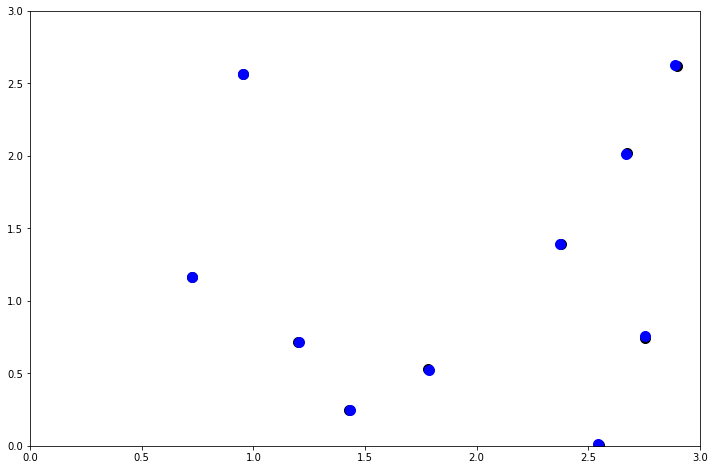

In [39]:
# plot particle positions (x-y)
i, j = 1, 3
plt.figure(figsize=(12,8))
for b in range(nbodies):
    plt.scatter(particle_data[0, b, i], particle_data[0, b, j], s=100, c='k')
    plt.scatter(particle_data[1:, b, i], particle_data[1:, b, j], s=1, c='r')
    plt.scatter(particle_data[-1, b, i], particle_data[-1, b, j], s=100, c='b')
plt.xlim(0, lBox)
plt.ylim(0, lBox)
plt.show()
plt.close()

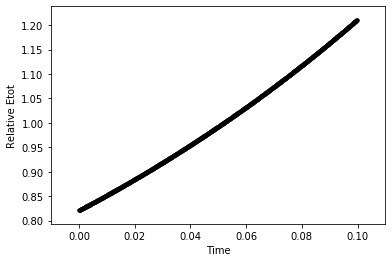

In [40]:
# plot energies
mean = np.mean(energies[:-1,3])
plt.scatter(energies[:-1,0], energies[:-1,3]/mean, c='k', s=10)

plt.xlabel("Time")
#plt.ylabel("Etot")
plt.ylabel("Relative Etot")
plt.show()

# Getting Natural Units
x' -> x/sigma
U'(r') = U(epsilon) = 4*(r'^12 - r'^-6)
d^2x'/dt^2 = sigma^-1 dx^2/dt^2 = ... = -eps/(sigma*m)*delta*U' 
hence: time in units of sqrt(sigma^2*m/eps): t' = sqrt(sigma^2*m/eps)*t
-> d^2x'/dt^2 = -delta U'(r')

for argon: sqrt(simga^2*m/eps) = 2.15*E-12 s

velocity
get it from equipartition theory: 1/2 mv^2 = 3/2 kB*T
-> v = sqrt(3kB*T/m)
then, natural unit of v:
v = sigma/t' = sigma/(sqrt(sigma^2*m/eps)) = sqrt(eps/m)
then : v(eqPart) / v(natur) = .. = sqrt(3kB*T/eps)
for Argon: eps/kB ~~ 100K
-> v/sqrt/eps/m) = O(1) for a simulation at ~~ 100K

hence get estimate for timestep: t' typical crossing time for particle to cross potential
-> get timestep dt < 1!
typically: 1E-3 - 1E-2

# 2. Milestone
- derive the expression of Ekin in dimless unites
- write MD code that uses dimless units and simulate a few atoms in 3D
- plot Ekin, Epot, Etot

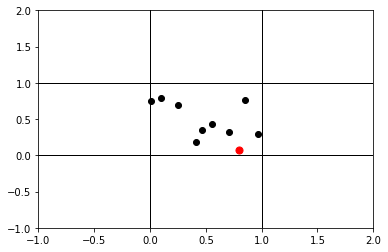

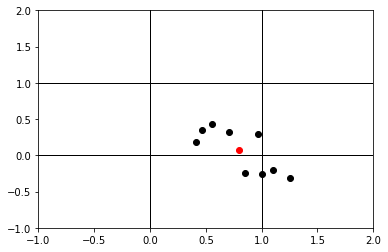

(-1, 2)

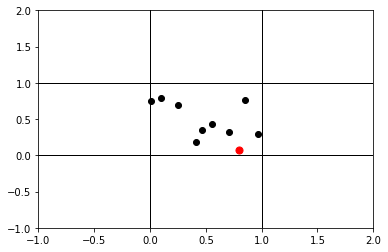

In [157]:
# x
# check min im conv
# original positions
plt.figure()
plt.scatter(particle_data[0, 1:, 1], particle_data[0, 1:, 2], c='k')
plt.scatter(particle_data[0, 0, 1], particle_data[0, 0, 2], c='r', s=50)
plt.axvline(x=1, c='k', lw=1)
plt.axvline(x=0, c='k', lw=1)
plt.axhline(y=1, c='k', lw=1)
plt.axhline(y=0, c='k', lw=1)

plt.xlim(-1, 2)
plt.ylim(-1, 2)
plt.show()
plt.close()

# remade positions wrt body 1
plt.figure()
body = particle_data[0, 0, :]
plt.scatter(particle_data[0, 0, 1], particle_data[0, 0, 2], c='r')

for p in particle_data[0, 1:]:
    recalc = Minimal_Image_Convention(S=0, Body=body, Other_Body=p, LBox=1)
    plt.scatter(recalc[1], recalc[2], c='k')
plt.axvline(x=1, c='k', lw=1)
plt.axvline(x=0, c='k', lw=1)
plt.axhline(y=1, c='k', lw=1)
plt.axhline(y=0, c='k', lw=1)

plt.xlim(-1, 2)
plt.ylim(-1, 2)
plt.show()
plt.close()

# check new positions
plt.figure()
plt.scatter(particle_data[0, 1:, 1], particle_data[0, 1:, 2], c='k')
plt.scatter(particle_data[0, 0, 1], particle_data[0, 0, 2], c='r', s=50)
plt.axvline(x=1, c='k', lw=1)
plt.axvline(x=0, c='k', lw=1)
plt.axhline(y=1, c='k', lw=1)
plt.axhline(y=0, c='k', lw=1)

plt.xlim(-1, 2)
plt.ylim(-1, 2)
#plt.show()
#plt.close()